In [1]:
suppressMessages(library("ImpulseDE2"))
suppressMessages(library(DESeq2))
suppressMessages(library(ggplot2))
#suppressMessages(library(ggrepel))
suppressMessages(library(tidyverse))
suppressMessages(library(ImpulseDE2))
suppressMessages(library(reshape2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(data.table))
suppressMessages(library(gsheet))

In [2]:
rm(list=ls())
#loading sample key 
sample_key = fread("/workdir/omm35/urine_plasma_cfRNA_comparison/metadata_key/plasma_urine_key.tsv")
sample_key$Record_ID=as.character(sample_key$Record_ID)

sample_key = sample_key  %>% filter(use_pair=="TRUE")
sample_key_urine = sample_key  
sample_key_plasma = sample_key


##For urine
sample_key_urine$sample_id = sample_key_urine$sample_id_urine

sample_key_urine = column_to_rownames(sample_key_urine, var = "sample_id_urine")
sample_key_urine$event_sym = factor(sample_key_urine$event_sym)
sample_key_urine = sample_key_urine %>% select(SubjectID,event_sym,sample_id,Record_ID,sample_id_plasma)
##For plasma

sample_key_plasma$sample_id = sample_key_plasma$sample_id_plasma
sample_key_plasma = column_to_rownames(sample_key_plasma, var = "sample_id_plasma")
sample_key_plasma$event_sym = factor(sample_key_plasma$event_sym)
sample_key_plasma = sample_key_plasma %>% select(SubjectID,event_sym,sample_id,Record_ID)

In [3]:
#loading clinical metadata
#############
patient_metadata = fread("/workdir/omm35/urine_cfRNA_analysis/metadata/patient_metadata.tsv")
patient_metadata = patient_metadata[,c("Record_ID","age","sex","group","hct_date")]
patient_metadata$Record_ID  = as.character(patient_metadata$Record_ID)

########## computing number of days since transplant
urinePlasmaMapping = sample_key_plasma %>% left_join(patient_metadata,by="Record_ID")
urinePlasmaMapping = urinePlasmaMapping[order(urinePlasmaMapping$sex,urinePlasmaMapping$SubjectID),] 

In [2]:
# head(urinePlasmaMapping)

In [3]:
patient_metadata = fread("/local/workdir/omm35/urine_cfRNA_analysis/metadata/sample_metadata.tsv")

patient_metadata$Record_ID=as.character(patient_metadata$Record_ID)


urinePlasmaMapping = urinePlasmaMapping  %>% left_join(patient_metadata, by=c("sample_id"))

In [7]:
patient_metadata = fread("/local/workdir/omm35/urine_cfRNA_analysis/metadata/sample_metadata.tsv")
colnames(patient_metadata)

In [8]:
gvhd_tissuesUrine = fread("/workdir/omm35/paper_urine_cfrna/CTO_refs_with_1000_sampling/cell_type_deconvolution_results/gvhd_plasma_ref_1000_properly_sampled_all_genes_marker_genes/gvhd_plasma_ref_1000_properly_sampled_all_genes_marker_genes_BP.protein_coding.tsv")
gvhd_tissuesUrine$sample_id=gsub("\\.","-",gvhd_tissuesUrine$sample_id)

In [10]:
tissuesUrine.long = melt(gvhd_tissuesUrine, id.vars = 'sample_id')
#new.df=urine_df  %>% filter(timepoint!="T0")

In [11]:
#tissuesUrine.long = melt(gvhd_tissuesUrine, id.vars = 'sample_id')

In [12]:
tissuesUrine.long = melt(gvhd_tissuesUrine, id.vars = 'sample_id')

tissuesUrine.long$variable=gsub("AKI_|HD_","",tissuesUrine.long$variable)
tissuesUrine.long = tissuesUrine.long %>% group_by(sample_id,variable) %>% summarise(value=sum(value))



#tissuesUrine.long = tissuesUrine.long %>% group_by(sample_id) %>% arrange(desc(value)) %>% slice(1:10)
tissuesUrine.long = tissuesUrine.long %>% group_by(sample_id) %>% arrange(desc(value)) 


tissuesUrine.long = tissuesUrine.long %>% group_by(sample_id) %>% mutate(sample_id = sample_id, variable="other", value=1-sum(value)) %>% bind_rows(tissuesUrine.long, .) %>% arrange(sample_id) %>% distinct()


tissuesUrine.combined.events = tissuesUrine.long %>% left_join(urinePlasmaMapping, by=c("sample_id"))

`summarise()` has grouped output by 'sample_id'. You can override using the `.groups` argument.


In [14]:
dim(tissuesUrine.combined.events)
qc_pass_samples = fread("/workdir/omm35/paper_urine_cfrna/metadata/QC_pass_samples.csv")
tissuesUrine.combined.events= tissuesUrine.combined.events[tissuesUrine.combined.events$sample_id  %in% qc_pass_samples$sample_id,]

[1] 34188    46

In [2]:
# unique(tissuesUrine.combined.events$variable)
# head(tissuesUrine.combined.events)

# significant_cells=c("club_cell_of_prostate_epithelium_hillock_cell_of_prostate_epithelium_hillock.club_cell_of_prostate_epithelium", 
#                   "duct_epithelial_cell","parietal_epithelial_cell","bladder_urothelial_cell" )

`summarise()` has grouped output by 'urine_Epithelial.cells.present', 'sample_id'. You can override using the `.groups` argument.


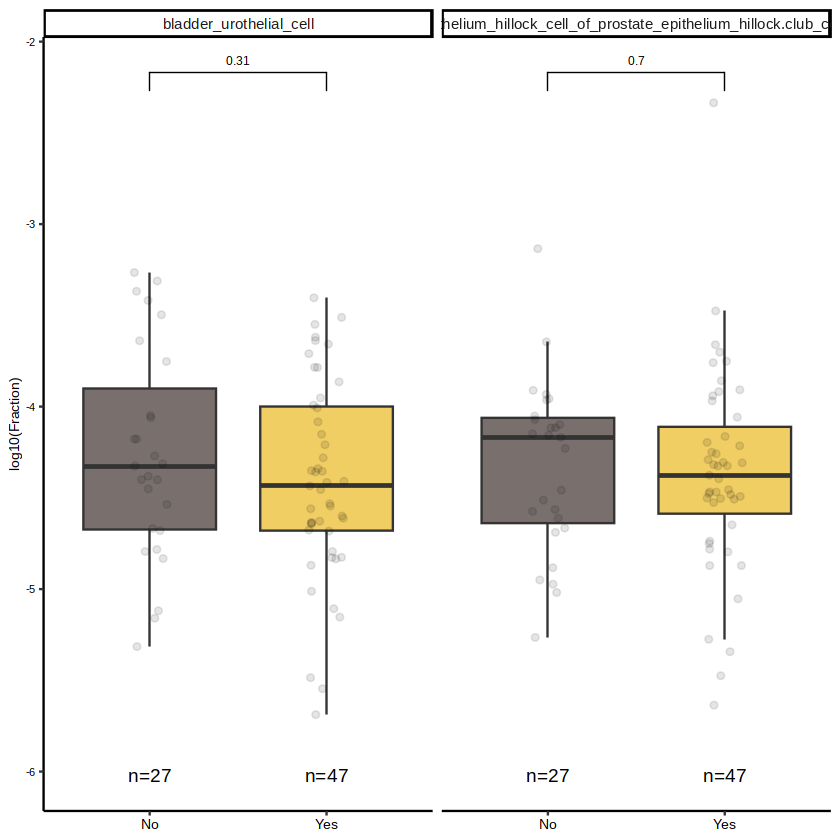

In [17]:
set.seed(1)
palette_function <- ggthemes::tableau_color_pal("Tableau 20")
all_colors <- palette_function(20)

cell_types=unique(tissuesUrine.combined.events$variable)
all_colors=sample(all_colors[5:15])

significant_cells=c("club_cell_of_prostate_epithelium_hillock_cell_of_prostate_epithelium_hillock.club_cell_of_prostate_epithelium", 
                    "bladder_urothelial_cell" 
                   )





urothelial = tissuesUrine.combined.events %>% filter(variable  %in% significant_cells)



urothelial = urothelial[!is.na(urothelial$urine_Epithelial.cells.present),]
urothelial = urothelial[urothelial$urine_Epithelial.cells.present=="Yes" | urothelial$urine_Epithelial.cells.present=="No",]


urothelial %>% dplyr::group_by(urine_Epithelial.cells.present,sample_id,variable) %>% summarise(value=sum(value)) %>% 
ggplot(.,aes(urine_Epithelial.cells.present,log10(value),fill= urine_Epithelial.cells.present))+ 
geom_boxplot(size=0.5, outlier.shape = NA)+ geom_point(position = position_jitterdodge( jitter.width = 0.2,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.1, )+ scale_fill_manual(values=all_colors) + theme_classic()+
ylab("log10(Fraction)") + xlab("Urine Epithelial Cell Present")+ 
ggpubr::stat_compare_means(
comparisons= list(c("No","Yes")),
method="wilcox",
p.adjust="bonferroni",
size = 2.5,
method.args=list(exact=TRUE,paired=FALSE)
)+ theme(
    #axis.title.x = element_text(size = 8,family = "Helvetica", color="black"),
    axis.title.x = element_blank(),
    axis.text.x = element_text(size = 8,family = "Helvetica", color="black"),
    axis.title.y = element_text(size = 8,family = "Helvetica", color="black"),
    axis.text.y = element_text(size=6,family = "Helvetica", color="black"),
    #legend.position = c(0.8, 0.8),
    legend.position = "none",
    legend.text = element_text(size=6),
    legend.title = element_blank(),
    legend.box.background = element_rect(),
  )+stat_n_text()+facet_wrap(variable~., ncol = 5)